In [17]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
#from tensorflow.keras.optimizers.Adam #RMSProp

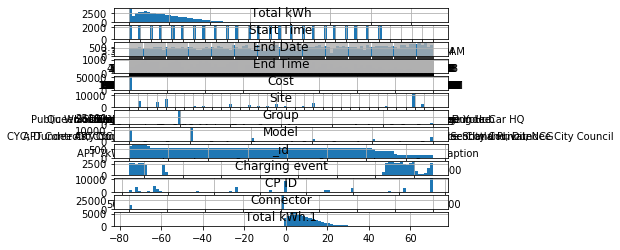

In [18]:
# histogram plots
from pandas import read_csv
from matplotlib import pyplot
# load the new file
#dataset = read_csv('EV_household_data_D.csv', header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
dataset = read_csv('Dundee_evcs.csv', header=0, infer_datetime_format=True, parse_dates=['Start Date'], index_col=['Start Date'])

#dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# histogram plot for each variable
pyplot.figure()
for i in range(len(dataset.columns)):
	pyplot.subplot(len(dataset.columns), 1, i+1)
	name = dataset.columns[i]
	dataset[name].hist(bins=100)
	pyplot.title(name, y=0)
pyplot.show()

In [19]:
dataset.describe()

,Total kWh,Cost,_id,Charging event,CP ID,Connector,Total kWh.1
count,52474.000000,52337.000000,52474.000000,5.247400e+04,52474.000000,52474.000000,52474.000000
mean,8.779105,0.000229,8473.747056,6.162121e+06,50891.052350,1.775279,8.752611
std,6.685029,0.030284,5155.448486,1.629384e+06,473.681257,0.430793,6.719681
min,0.000000,0.000000,1.000000,3.801463e+06,50230.000000,1.000000,-75.490000
25%,3.720000,0.000000,4002.000000,3.997253e+06,50349.000000,2.000000,3.711000
50%,7.480000,0.000000,8384.500000,7.214544e+06,50911.000000,2.000000,7.470000
75%,12.634750,0.000000,12774.000000,7.404129e+06,51422.000000,2.000000,12.630000
max,75.490000,4.000000,19227.000000,7.751157e+06,51550.000000,3.000000,70.984000


In [20]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# calculate mape
		mape = np.mean(np.abs((actual[:,i] - predicted[:,i]) / actual[:,i]))*100 
		mae = np.mean(np.abs((actual[:,i] - predicted[:,i])))
		# store
		scores.append(mse)#mape, mse, rmse, mae
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1])) # #sqrt
	# plot the results
#	print(predicted)
#	print(actual)
	fig = plt.figure()
	pyplot.plot(actual[:,5],marker='x',color='green', label = 'actual')
	pyplot.plot(predicted[:,5],marker='o', label = 'predicted')
	pyplot.legend()  
	plt.xlabel('Time')
	plt.ylabel('Normalized Electricity load')
	pyplot.show()
	fig.savefig('output_load_forecasting.jpg', bbox_inches='tight')    
	return score, scores

In [21]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
 
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
#			X.append(data[in_start:in_end, :])   #multivariate change         
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [27]:
# train the model BiCONVLSTM-LSTM
def build_model(train, n_steps, n_length, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 1000, 64
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape into subsequences [samples, time steps, rows, cols, channels]
	train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model with 4 convlstm and 2 LSTM layers
	model = Sequential()
##	model.add(ConvLSTM2D(filters=128, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features), return_sequences = True)) 
#	model.add(BatchNormalization())
##	model.add((ConvLSTM2D(64, kernel_size = (1, 3), activation='relu', padding = 'same', return_sequences = True)))
##	model.add((ConvLSTM2D(32, kernel_size = (1, 3), activation='relu', padding = 'same', return_sequences = True)))
##	model.add((ConvLSTM2D(16, kernel_size = (1, 3), activation='relu', padding = 'same', return_sequences = True)))    
#	model.add(BatchNormalization())    
	model.add(Bidirectional(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features), return_sequences = True)))
#	model.add(Bidirectional(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', return_sequences = True)))
#	model.add(Bidirectional(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', return_sequences = True)))
#	model.add(Bidirectional(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', return_sequences = True)))
#	model.add(BatchNormalization())    
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
#	model.add(Bidirectional(LSTM(200, activation='relu',kernel_regularizer=regularizers.l2(0.001), return_sequences=True)))#     
	model.add((LSTM(200, activation='relu',kernel_regularizer=regularizers.l2(0.001), return_sequences=True)))# 
#	model.add(Dropout(0.2))      
	model.add((LSTM(200, activation='relu', kernel_regularizer=regularizers.l2(0.001),return_sequences=True))) # kernel_regularizer=regularizers.l2(0.001),   
#	model.add(Dropout(0.2))  
#	model.add((LSTM(200, activation='relu', return_sequences=True)))    
#	model.add((LSTM(200, activation='relu', return_sequences=True)))    
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	opt = tf.keras.optimizers.Adam(learning_rate = 0.01)
	model.compile(loss='mse', optimizer=opt)
	# fit network
	# fit network
	history = model.fit(train_x, train_y, epochs=epochs, validation_split=0.01,batch_size=batch_size, verbose=verbose)
	model.summary()
# Add title and axis names
	plt.title('BiCONVLSTM-LSTM')    
	pyplot.plot(history.history['loss'], label='train')
	pyplot.plot(history.history['val_loss'], label='val')
	pyplot.legend()
	plt.xlim(0, 1000)
	plt.ylim(0, 1)    
	plt.xlabel('Epochs')
	plt.ylabel('MSE')
	pyplot.show()      

	return model

In [28]:
# train the model BiCONVLSTM-BiLSTM
def build_model(train, n_steps, n_length, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 100, 64
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape into subsequences [samples, time steps, rows, cols, channels]
	train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model with 4 convlstm and 2 LSTM layers
	model = Sequential()  
	model.add(Bidirectional(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features), return_sequences = True)))
	model.add(Bidirectional(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', return_sequences = True)))
#	model.add(Bidirectional(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features), return_sequences = True)))
#	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='elu', return_sequences = False))
#	model.add(BatchNormalization())    
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))##
	model.add(Bidirectional(LSTM(200, activation='relu',kernel_regularizer=regularizers.l2(0.01), return_sequences=True)))
#	model.add(Dropout(0.5))
	model.add(Bidirectional(LSTM(200, activation='relu',kernel_regularizer=regularizers.l2(0.01), return_sequences=True))) 
#	model.add(Dropout(0.5))
##	model.add((LSTM(200, activation='relu',kernel_regularizer=regularizers.l2(0.001), return_sequences=True)))# 
#	model.add(Dropout(0.5))      
##	model.add((LSTM(200, activation='relu', kernel_regularizer=regularizers.l2(0.001),return_sequences=True))) # kernel_regularizer=regularizers.l2(0.001),   
##	model.add(Dropout(0.5))  
#	model.add((LSTM(200, activation='relu', return_sequences=True)))    
#	model.add((LSTM(200, activation='relu', return_sequences=True)))    
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	# fit network
	history = model.fit(train_x, train_y, epochs=epochs, validation_split=0.01,batch_size=batch_size, verbose=verbose)
	model.summary()
# Add title and axis names
	plt.title('BiCONVLSTM-BiLSTM')
	pyplot.plot(history.history['loss'], label='train')
	pyplot.plot(history.history['val_loss'], label='val')
	pyplot.legend()
	plt.xlim(0, 1000)
	plt.ylim(0, 1)    
	plt.xlabel('Epochs')
	plt.ylabel('MSE')
	pyplot.show()      

	return model

In [28]:
## conv-lstm
# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:,0]     # 0 for univariate and : fro mutivariate
	# reshape into [samples, time steps, rows, cols, channels]
	input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    
	# retrieve last observations for input data
#	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
#	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))    
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [29]:
# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input):
	# fit model
	model = build_model(train, n_steps, n_length, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 2, 1, 5, 128)     100352    
 nal)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 1280)              0         
                                                                 
 repeat_vector_4 (RepeatVect  (None, 7, 1280)          0         
 or)                                                             
                                                                 
 lstm_8 (LSTM)               (None, 7, 200)            1184800   
                                                                 
 lstm_9 (LSTM)               (None, 7, 200)            320800    
                                                                 
 time_distributed_8 (TimeDis  (None, 7, 100)          

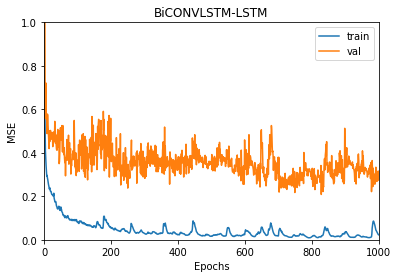

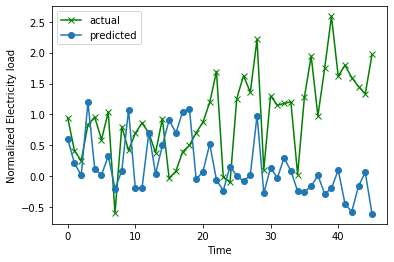

Biconvlstm-lstm: [1.126] 0.8, 1.7, 1.1, 1.9, 1.4, 1.5, 0.5


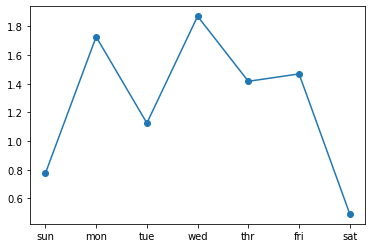

In [31]:
# load the new file
#dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
#dataset = read_csv('modelData_season_daily.csv', header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
#dataset = read_csv('ISONE_daily.csv', header=0, infer_datetime_format=True, parse_dates=['date'], index_col=['date'])
#dataset = read_csv('EV_household_data_D.csv', header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
dataset = read_csv('PAevse_D.csv', header=0, infer_datetime_format=True, parse_dates=['Start Date'], index_col=['Start Date'])
#Devcs, Pthevcs, PAevse, Bevse, elaadevcs

#Standardize the dataset
data_mean = dataset[:].mean(axis=0)
data_std = dataset[:].std(axis=0)
dataset = (dataset-data_mean)/data_std

# split into train and test
train, test = split_dataset(dataset.values)
# define the number of subsequences and the length of subsequences
n_steps, n_length = 2,7
# define the total days to use as input
n_input = n_length * n_steps
score, scores = evaluate_model(train, test, n_steps, n_length, n_input)
# summarize scores
summarize_scores('Biconvlstm-lstm', score, scores)

# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

In [41]:
Devcs_D.describe()

NameError: name 'Devcs_D' is not defined

In [14]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg



In [16]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

In [17]:
# load dataset
dataset = read_csv('household_power_consumption_days.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)



(1439, 32)


In [18]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



(1439, 24) 1439 (1439,)
(1439, 3, 8) (1439,) (0, 3, 8) (0,)


In [28]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))




Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23/23 - 1s - loss: 0.0390 - 1s/epoch - 61ms/step
Epoch 2/100
23/23 - 0s - loss: 0.0123 - 64ms/epoch - 3ms/step
Epoch 3/100
23/23 - 0s - loss: 0.0112 - 69ms/epoch - 3ms/step
Epoch 4/100
23/23 - 0s - loss: 0.0106 - 63ms/epoch - 3ms/step
Epoch 5/100
23/23 - 0s - loss: 0.0104 - 62ms/epoch - 3ms/step
Epoch 6/100
23/23 - 0s - loss: 0.0102 - 67ms/epoch - 3ms/step
Epoch 7

ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [27]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

NameError: name 'yhat' is not defined